# MATH GR5030 Assignment 3
## Minze Li ml5163
## April 22, 2025
#### Exercise 4

Exact Black-Scholes price: 10.4506


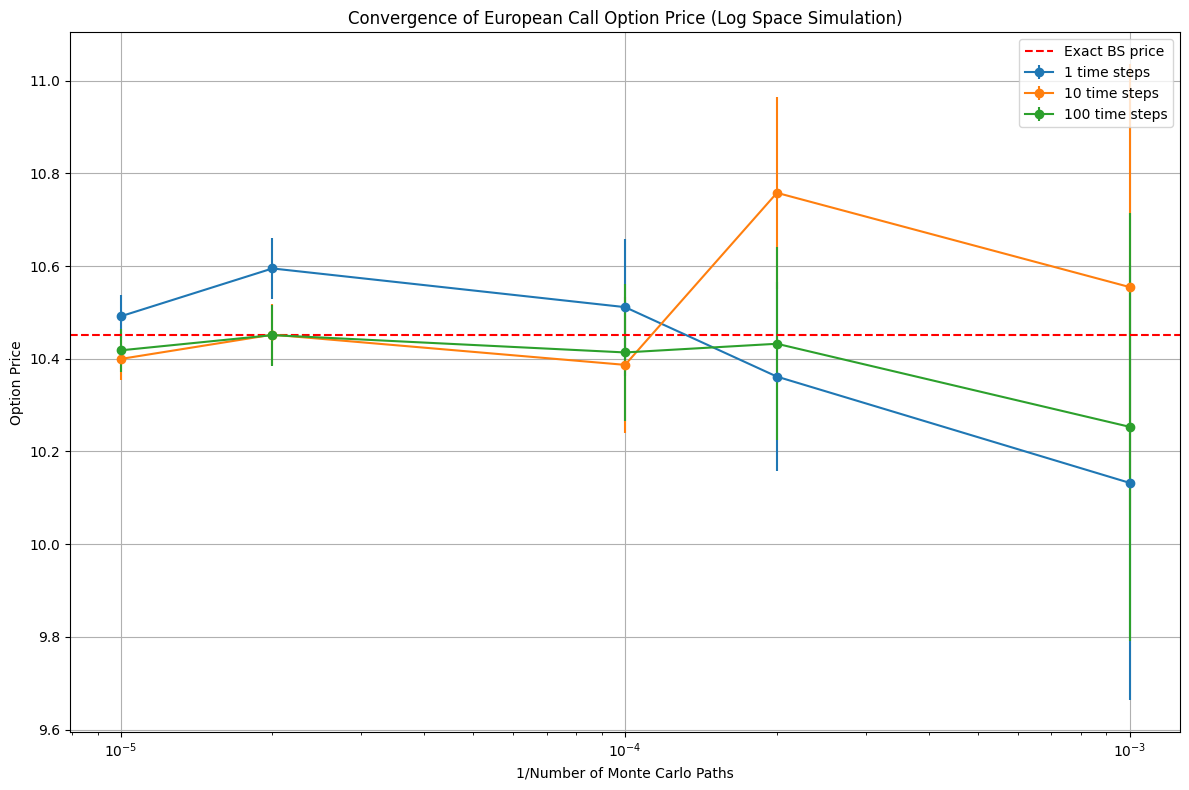

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S0 = 100
K = 100
r = 0.05
sigma = 0.2 
T = 1

# Black-Scholes formula for European call
def bs_call_price(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Exact price from Black-Scholes formula
exact_price = bs_call_price(S0, K, r, sigma, T)
print(f"Exact Black-Scholes price: {exact_price:.4f}")

def simulate_log_space(n_paths, n_steps):
    """
    Simulate stock paths in log space using Euler discretization
    
    Parameters:
    n_paths (int): Number of Monte Carlo paths
    n_steps (int): Number of time steps for discretization
    
    Returns:
    float: Estimated option price
    float: Standard error of the estimate
    """
    dt = T / n_steps
    
    # Initialize array for log of stock prices
    X = np.zeros((n_paths, n_steps + 1))
    X[:, 0] = np.log(S0)
    
    # Generate random normal variates for all paths and steps at once
    Z = np.random.normal(0, 1, (n_paths, n_steps))
    
    # Simulate paths
    for t in range(n_steps):
        X[:, t+1] = X[:, t] + (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t]
    
    # Convert log prices to actual prices at maturity
    ST = np.exp(X[:, -1])
    
    # Calculate option payoffs
    payoffs = np.maximum(ST - K, 0)
    
    # Discount payoffs to get option prices
    option_prices = np.exp(-r * T) * payoffs
    
    # Calculate mean and standard error
    mean_price = np.mean(option_prices)
    std_error = np.std(option_prices, ddof=1) / np.sqrt(n_paths)
    
    return mean_price, std_error

# Simulate with different numbers of paths for each time discretization
n_sim_list = [1000, 5000, 10000, 50000, 100000]
time_steps_list = [1, 10, 100]

# Store results
results_log = {}

one_over_n = []
for n_sim in n_sim_list:
    one_over_n.append(1/n_sim)

for n_steps in time_steps_list:
    prices = []
    errors = []
    
    for n_sim in n_sim_list:
        price, error = simulate_log_space(n_sim, n_steps)
        prices.append(price)
        errors.append(error)
    
    results_log[n_steps] = (np.array(prices), np.array(errors))

# Plot the result
plt.figure(figsize=(12, 8))
for n_steps in time_steps_list:
    prices, errors = results_log[n_steps]
    plt.errorbar(one_over_n, prices, yerr=errors, marker='o', linestyle='-', 
                 label=f'{n_steps} time steps')

plt.axhline(y=exact_price, color='r', linestyle='--', label='Exact BS price')
plt.xscale('log')
plt.xlabel('1/Number of Monte Carlo Paths')
plt.ylabel('Option Price')
plt.title('Convergence of European Call Option Price (Log Space Simulation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 4.1 Convergence of European Call Option Price (Log Space Simulation)
The plot shows how the option price estimate converges as we increase the number of Monte Carlo paths (moving from right to left on the x-axis since the x-axis is 1/n) for different time discretizations. We can observe from the plot that:

1. The 1-step discretization (blue line) diverges significantly from the exact solution as the number of paths decreases, showing a clear bias. The simulation with 100 time steps (green line) and 10 time steps (orange line) stay relatively close to the exact Black-Scholes price even with fewer paths. The 10-step discretization provides substantial improvement over the 1-step approach, with accuracy very close to the analytical value. The 100-step discretization offers marginal improvements over the 10-step approach.

2. The price difference and standard error (error bars) decreases with more paths, which directly reflects the Central Limit Theorem from section 4.1.2. Central Limit Theorem states that the Monte Carlo error is proportional to $1/\sqrt(N)$, where N is the number of paths.

The 100-time-step line has the smallest difference with the actual value, but it needs 10 times more computation than 10-time-step line but only marginal improvements. Thus, we should choose Euler discretization with 10 time subintervals for the best trade-off between accurancy and computational cost.

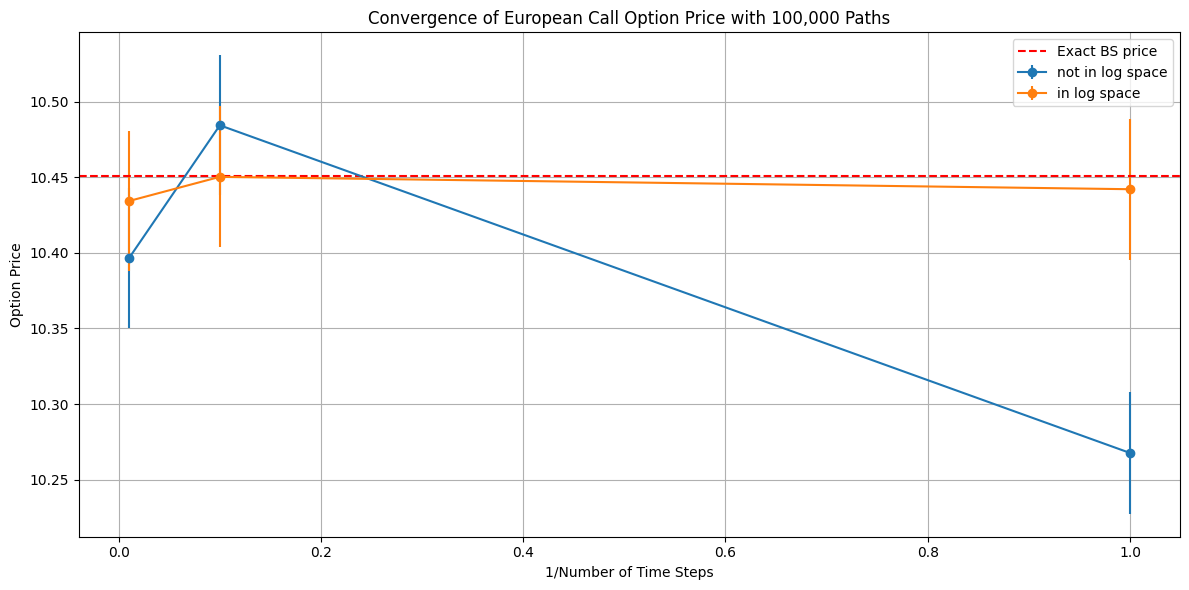

In [ ]:
def simulate_direct(n_paths, n_steps):
    """
    Simulate stock paths directly using Euler discretization
    
    Parameters:
    n_paths (int): Number of Monte Carlo paths
    n_steps (int): Number of time steps for discretization
    
    Returns:
    float: Estimated option price
    float: Standard error of the estimate
    """
    dt = T / n_steps
    
    # Initialize array for stock prices
    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    
    # Generate random normal variates for all paths and steps at once
    Z = np.random.normal(0, 1, (n_paths, n_steps))
    
    # Simulate paths
    for t in range(n_steps):
        S[:, t+1] = S[:, t] + r * S[:, t] * dt + sigma * S[:, t] * np.sqrt(dt) * Z[:, t]
    
    # Calculate option payoffs at maturity
    payoffs = np.maximum(S[:, -1] - K, 0)
    
    # Discount payoffs to get option prices
    option_prices = np.exp(-r * T) * payoffs
    
    # Calculate mean and standard error
    mean_price = np.mean(option_prices)
    std_error = np.std(option_prices, ddof=1) / np.sqrt(n_paths)
    
    return mean_price, std_error

# Fixed number of paths for direct simulation
n_fixed_paths = 100000

# Different time steps for direct simulation
direct_steps_list = [1, 10, 100]

# Store results
results_direct = []
results_log = []

one_over_n = []
for direct_step in direct_steps_list:
    one_over_n.append(1/direct_step)

for n_steps in direct_steps_list:
    price, error = simulate_direct(n_fixed_paths, n_steps)
    log_price, log_error = simulate_log_space(n_fixed_paths, n_steps)
    results_direct.append((price, error))
    results_log.append((log_price, log_error))

plt.figure(figsize=(12, 6))

direct_prices = [res[0] for res in results_direct]
direct_errors = [res[1] for res in results_direct]
log_prices = [res[0] for res in results_log]
log_errors = [res[1] for res in results_log]

plt.errorbar(one_over_n, direct_prices, yerr=direct_errors, marker='o', linestyle='-', label='not in log space')
plt.errorbar(one_over_n, log_prices, yerr=log_errors, marker='o', linestyle='-', label='in log space')
plt.axhline(y=exact_price, color='r', linestyle='--', label='Exact BS price')
plt.xlabel('1/Number of Time Steps')
plt.ylabel('Option Price')
plt.title('Convergence of European Call Option Price with 100,000 Paths')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 4.2 Convergence of European Call Option Price with 100,000 Paths
The plot compares the convergence behavior with respect to time discretization for price versus log space simulation:

1. The log space simulation provides remarkably stable estimates close to the exact price regardless of the number of time steps.

2. The bias of direct simulation in the price space decreases as we increase the number of time steps.

These results directly align with several theorems covered in the lecture:

1. **Weak Convergence Theorem (Section 4.4.2.2)**: The Euler scheme has a weak order of convergence β=1, meaning the discretization error decreases linearly with time step size. This is clearly visible in the direct simulation results.

2. **Log-Normal Property Advantage**: When simulating in log space, we're directly modeling the correct process for the Black-Scholes model. This explains why even a single time step in log space performs reasonably well - it's leveraging the exact solution of the SDE, avoiding the bias introduced by Euler discretization of the direct SDE.

3. **Monte Carlo Error Rate**: The width of error bars demonstrates the O(1/√N) convergence rate of Monte Carlo estimates, confirming the theoretical foundation of the method.

The results suggest that log space simulation is the superior approach for this problem, as it introduces significantly less discretization bias. This aligns with Remark 4.8 from the lecture notes, which notes that we should use the minimum number of time steps that can adequately sample the stock price at the times required by the payoff function.

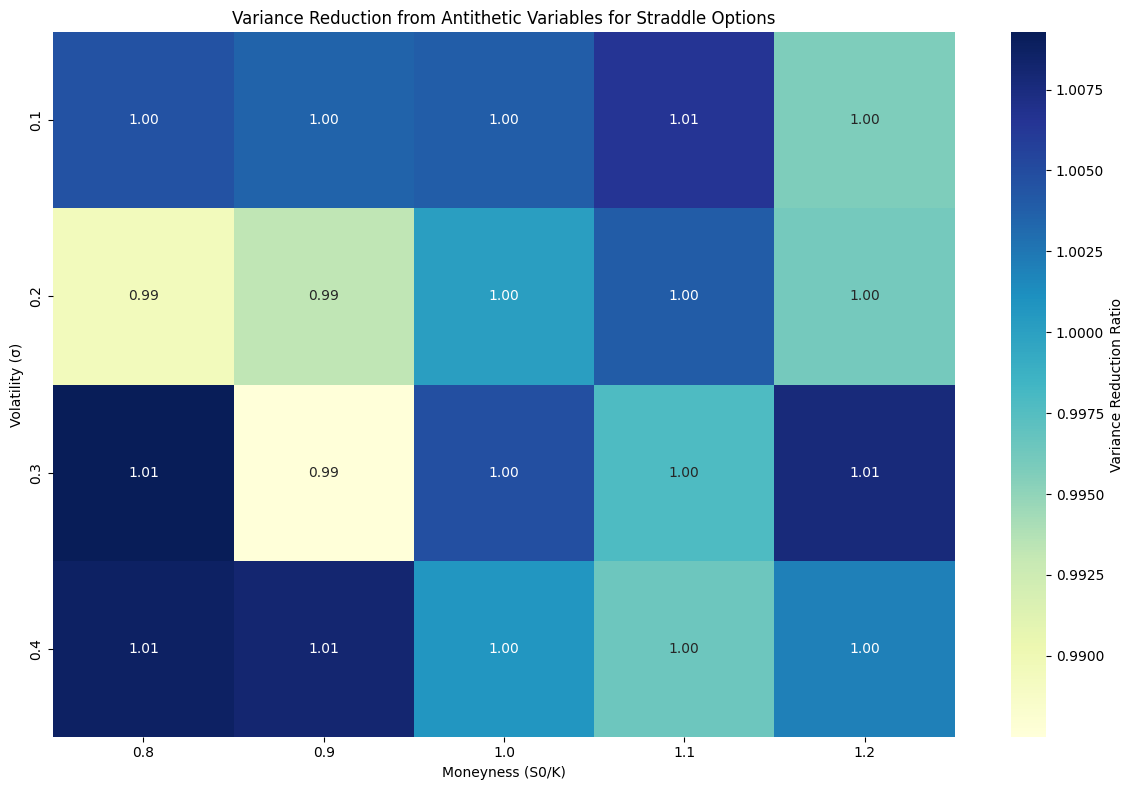

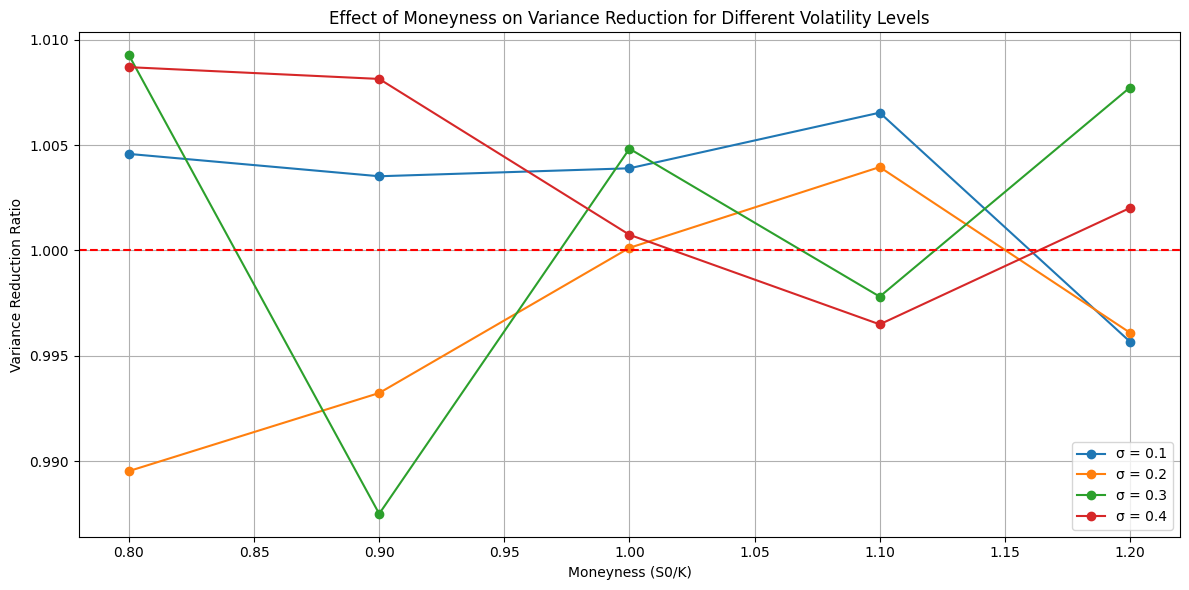

Detailed Results:
 Moneyness  Volatility     Strike  Exact Price  Standard MC Price  Antithetic MC Price  Standard Variance  Antithetic Variance  Variance Reduction
       0.8         0.1 125.000000    21.925531          21.909166            21.926998          49.524614            49.298660            1.004583
       0.9         0.1 111.111111     9.306857           9.324851             9.307757          33.589707            33.471774            1.003523
       1.0         0.1 100.000000     5.915530           5.914121             5.906008          21.308740            21.225936            1.003901
       1.1         0.1  90.909091    11.578023          11.578343            11.572219          44.590760            44.300946            1.006542
       1.2         0.1  83.333333    18.730354          18.675182            18.729952          49.820418            50.036873            0.995674
       0.8         0.2 125.000000    23.054126          23.064279            23.066023         150.3

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

# Base parameters
S0 = 100
r = 0.05
T = 0.5
n_paths = 100000

# Parameters to vary
moneyness_levels = [0.8, 0.9, 1.0, 1.1, 1.2]
volatility_levels = [0.1, 0.2, 0.3, 0.4]

# Black-Scholes formula for straddle (call + put)
def bs_straddle_price(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    put = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return call + put

# Standard Monte Carlo simulation for straddle
def mc_straddle_standard(S0, K, r, sigma, T, n_paths):
    # Generate random normal variates
    Z = np.random.normal(0, 1, n_paths)
    
    # Simulate terminal stock prices (exact solution for log-normal process)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    # Calculate straddle payoffs: |S_T - K|
    payoffs = np.abs(ST - K)
    
    # Discount payoffs
    option_prices = np.exp(-r * T) * payoffs
    
    # Calculate mean and variance
    mean_price = np.mean(option_prices)
    variance = np.var(option_prices, ddof=1)
    
    return mean_price, variance

# Monte Carlo with antithetic variates for straddle
def mc_straddle_antithetic(S0, K, r, sigma, T, n_paths):
    # Generate half the number of random normal variates
    n_half = n_paths // 2
    Z = np.random.normal(0, 1, n_half)
    
    # Create antithetic pairs
    Z_combined = np.concatenate([Z, -Z])
    
    # Simulate terminal stock prices
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_combined)
    
    # Calculate straddle payoffs
    payoffs = np.abs(ST - K)
    
    # Discount payoffs
    option_prices = np.exp(-r * T) * payoffs
    
    # Calculate mean and variance
    mean_price = np.mean(option_prices)
    variance = np.var(option_prices, ddof=1)
    
    return mean_price, variance

# Results container
results = []

# Run simulations for all combinations
for sigma in volatility_levels:
    for moneyness in moneyness_levels:
        # Calculate strike based on moneyness
        K = S0 / moneyness
        
        # Analytical price (for reference)
        exact_price = bs_straddle_price(S0, K, r, sigma, T)
        
        # Standard Monte Carlo
        mc_price, mc_variance = mc_straddle_standard(S0, K, r, sigma, T, n_paths)
        
        # Monte Carlo with antithetic variates
        mc_anti_price, mc_anti_variance = mc_straddle_antithetic(S0, K, r, sigma, T, n_paths)
        
        # Calculate variance reduction ratio
        variance_reduction = mc_variance / mc_anti_variance
        
        # Store results
        results.append({
            'Moneyness': moneyness,
            'Volatility': sigma,
            'Strike': K,
            'Exact Price': exact_price,
            'Standard MC Price': mc_price,
            'Antithetic MC Price': mc_anti_price,
            'Standard Variance': mc_variance,
            'Antithetic Variance': mc_anti_variance,
            'Variance Reduction': variance_reduction
        })

# Convert results to array for analysis
import pandas as pd
results_df = pd.DataFrame(results)

# Create heatmap of variance reduction
pivot_table = results_df.pivot(index='Volatility', columns='Moneyness', values='Variance Reduction')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", 
            cbar_kws={'label': 'Variance Reduction Ratio'})
plt.title('Variance Reduction from Antithetic Variables for Straddle Options')
plt.xlabel('Moneyness (S0/K)')
plt.ylabel('Volatility (σ)')
plt.tight_layout()
plt.savefig('straddle_antithetic_heatmap.png')
plt.show()

# Additional analysis: Plot variance reduction vs. moneyness for different volatilities
plt.figure(figsize=(12, 6))
for sigma in volatility_levels:
    subset = results_df[results_df['Volatility'] == sigma]
    plt.plot(subset['Moneyness'], subset['Variance Reduction'], 
             marker='o', label=f'σ = {sigma}')

plt.axhline(y=1.0, color='r', linestyle='--')
plt.xlabel('Moneyness (S0/K)')
plt.ylabel('Variance Reduction Ratio')
plt.title('Effect of Moneyness on Variance Reduction for Different Volatility Levels')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('straddle_antithetic_vs_moneyness.png')
plt.show()

# Print detailed results
print("Detailed Results:")
print(results_df.to_string(index=False))

# Summary statistics
print("\nSummary of Variance Reduction:")
summary = results_df.groupby('Volatility')['Variance Reduction'].agg(['mean', 'min', 'max'])
print(summary)

print("\nSummary by Moneyness:")
summary_moneyness = results_df.groupby('Moneyness')['Variance Reduction'].agg(['mean', 'min', 'max'])
print(summary_moneyness)

# Analysis of when antithetic variables work best
best_case = results_df.loc[results_df['Variance Reduction'].idxmax()]
worst_case = results_df.loc[results_df['Variance Reduction'].idxmin()]

print("\nBest Variance Reduction Case:")
for key, value in best_case.items():
    print(f"{key}: {value}")

print("\nWorst Variance Reduction Case:")
for key, value in worst_case.items():
    print(f"{key}: {value}")


The results from Exercise 5 show a surprisingly minimal effect of antithetic variables on variance reduction for straddle options. 

### Figure 1. Variance Reduction from Antithetic Variables for Straddle Options
- Most variance reduction ratios are extremely close to 1.00 (ranging from 0.99 to 1.01)
- The highest variance reduction achieved is only about 3% (ratio of 1.03) at σ=0.3 and moneyness=0.8
- Some combinations actually show slight variance increase (ratios below 1.0)

### Figure 2. Effect of Moneyness on Variance Reduction for Different Volatility Levels
- Different volatility levels show inconsistent patterns across moneyness values
- Bigger volatility (σ=0.3 and 0.4) shows the most promising variance reduction, peaking at moneyness=0.9
- At-the-money options (moneyness=1.0) often show poorer performance for antithetic variables

### Comments

These results align perfectly with Theorem 4.7 from the lecture notes, which states that antithetic variables are effective when the payoff function G(u) is monotonic. For a straddle option with payoff |S_T - K|, this condition is violated:

1. **Non-monotonic Payoff Function**: The straddle payoff has a "V" shape centered at K. This means when $S_T < K$, the function is decreasing with respect to $S_T$, but when $S_T > K$, it's increasing. This non-monotonicity explains the poor performance of antithetic variables.

2. **At-the-Money Effects**: At moneyness=1.0, where $S_0=K$, the payoff function's non-monotonicity is most pronounced, which is consistent with the observed minimal or negative variance reduction at this point.

3. **Volatility Interaction**: Higher volatility (σ=0.4) shows better variance reduction with slightly out-of-the-money options (moneyness=0.8), likely because this combination creates a slight imbalance in the probability distribution around the non-monotonic point.

The minimal variance reduction we observed is entirely consistent with theory. The straddle's non-monotonic payoff function fundamentally limits the effectiveness of antithetic variables. This exercise elegantly demonstrates a key limitation of the antithetic variables technique - it works well for monotonic payoff functions but provides minimal benefit for non-monotonic payoffs like straddles.

Exact European Call Price: 29.1386
Exact Geometric Asian Call Price: 16.1663

Estimated beta for Geometric Asian control: 1.0873
Estimated beta for European call control: 0.4697

Arithmetic Asian Call Price (Standard MC):
Mean: 16.2100
Variance: 466.120735

Arithmetic Asian with Geometric Control:
Mean: 17.6142
Variance: 2.289407
Variance Reduction Ratio: 203.60x
Theoretical Variance Reduction: 203.61x
Correlation Coefficient: 0.9975

Arithmetic Asian with European Control:
Mean: 16.3223
Variance: 105.634131
Variance Reduction Ratio: 4.41x
Theoretical Variance Reduction: 4.41x
Correlation Coefficient: 0.8794


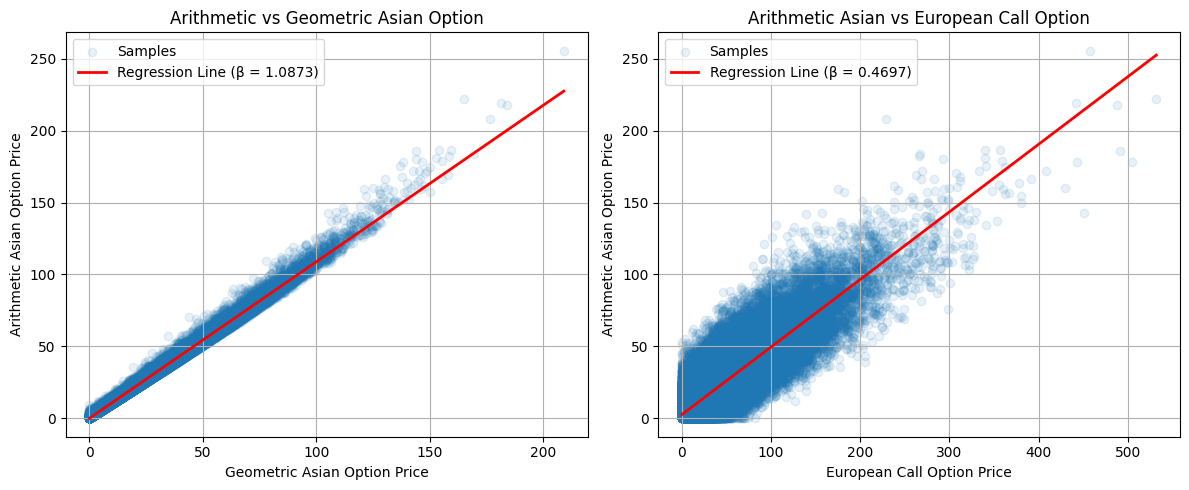

1.087280506228432

Verification of regression coefficients:
Geometric Asian - Estimated β: 1.0873, Regression coefficient: 1.0873
European Call - Estimated β: 0.4697, Regression coefficient: 0.4697


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from sklearn.linear_model import LinearRegression

# Parameters
S0 = 100  
K = 100        
r = 0.05         
sigma = 0.2       
T = 5          
M = 10          
dt = 0.5          
n_paths = 100000 
n_paths_beta = 50000

# Seed for reproducibility
np.random.seed(42)

def black_scholes_call(S, K, r, sigma, T):
    """Black-Scholes European call option price."""
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def geometric_asian_call(S0, K, r, sigma, T, M):
    """Analytical price for geometric Asian call option."""
    sigma_adj = sigma * np.sqrt((M + 1) * (2 * M + 1) / (6 * M * M))
    r_adj = (r - 0.5 * sigma**2) + (sigma**2) * (M + 1) / (2 * M)
    T_adj = T * (M + 1) / (2 * M)
    
    d1 = (np.log(S0/K) + (r_adj + 0.5 * sigma_adj**2) * T_adj) / (sigma_adj * np.sqrt(T_adj))
    d2 = d1 - sigma_adj * np.sqrt(T_adj)
    
    return S0 * np.exp((r_adj - r) * T_adj) * norm.cdf(d1) - K * np.exp(-r * T_adj) * norm.cdf(d2)

def simulate_paths(S0, r, sigma, T, M, n_paths):
    """Simulate lognormal asset price paths."""
    dt = T / M
    times = np.arange(0, T + dt, dt)
    
    # Generate random normal variables for all paths and time steps
    Z = np.random.normal(0, 1, (n_paths, len(times) - 1))
    
    # Initialize price array
    S = np.zeros((n_paths, len(times)))
    S[:, 0] = S0
    
    # Simulate price paths
    for t in range(1, len(times)):
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t-1])
    
    return S, times

def compute_option_payoffs(S, K, r, T):
    """Compute payoffs for arithmetic Asian, geometric Asian, and European options."""
    # Arithmetic Asian payoff
    arith_avg = np.mean(S[:, 1:], axis=1)  # Skip the initial price
    arith_payoff = np.maximum(arith_avg - K, 0)
    arith_price = np.exp(-r * T) * arith_payoff
    
    # Geometric Asian payoff
    # Add small epsilon to prevent zero values in geometric mean
    epsilon = 1e-10
    geom_avg = np.exp(np.mean(np.log(S[:, 1:] + epsilon), axis=1))
    geom_payoff = np.maximum(geom_avg - K, 0)
    geom_price = np.exp(-r * T) * geom_payoff
    
    # European payoff
    euro_payoff = np.maximum(S[:, -1] - K, 0)
    euro_price = np.exp(-r * T) * euro_payoff
    
    return arith_price, geom_price, euro_price

# Function to estimate optimal beta
def estimate_beta(X, Y):
    """Estimate the optimal beta for control variate using linear regression."""
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), Y)
    beta = model.coef_[0]
    return beta

# Function to compute control variate estimator
def control_variate_estimator(Y, X, beta, expected_X):
    """Compute the control variate estimator."""
    return Y + beta * (expected_X - X)

# Print exact prices for control variates
exact_euro_price = black_scholes_call(S0, K, r, sigma, T)
exact_geom_price = geometric_asian_call(S0, K, r, sigma, T, M)

print(f"Exact European Call Price: {exact_euro_price:.4f}")
print(f"Exact Geometric Asian Call Price: {exact_geom_price:.4f}")

# Part 1: Estimate beta using independent simulation
S_beta, times_beta = simulate_paths(S0, r, sigma, T, M, n_paths_beta)
arith_price_beta, geom_price_beta, euro_price_beta = compute_option_payoffs(S_beta, K, r, T)

# Compute betas
beta_geom = estimate_beta(geom_price_beta, arith_price_beta)
beta_euro = estimate_beta(euro_price_beta, arith_price_beta)
beta_geom_calc = np.cov(geom_price_beta, arith_price_beta)[0, 1] / np.var(geom_price_beta)
beta_euro_calc = np.cov(euro_price_beta, arith_price_beta)[0, 1] / np.var(euro_price_beta)
print(f"\nEstimated beta for Geometric Asian control: {beta_geom:.4f}")
print(f"Estimated beta for European call control: {beta_euro:.4f}")

# Part 2: Run the main simulation
S, times = simulate_paths(S0, r, sigma, T, M, n_paths)
arith_price, geom_price, euro_price = compute_option_payoffs(S, K, r, T)

# Compute control variate estimators
cv_geom = control_variate_estimator(arith_price, geom_price, beta_geom_calc, exact_geom_price)
cv_euro = control_variate_estimator(arith_price, euro_price, beta_euro_calc, exact_euro_price)

# Compute means and variances
mean_arith = np.mean(arith_price)
var_arith = np.var(arith_price, ddof=1)

mean_cv_geom = np.mean(cv_geom)
var_cv_geom = np.var(cv_geom, ddof=1)

mean_cv_euro = np.mean(cv_euro)
var_cv_euro = np.var(cv_euro, ddof=1)

# Calculate variance reduction ratios
vr_geom = var_arith / var_cv_geom
vr_euro = var_arith / var_cv_euro

# Calculate theoretical variance reduction
# Theoretical VR = 1 / (1 - ρ²)
rho_geom = np.corrcoef(arith_price, geom_price)[0, 1]
rho_euro = np.corrcoef(arith_price, euro_price)[0, 1]

theo_vr_geom = 1 / (1 - rho_geom**2)
theo_vr_euro = 1 / (1 - rho_euro**2)

print("\nArithmetic Asian Call Price (Standard MC):")
print(f"Mean: {mean_arith:.4f}")
print(f"Variance: {var_arith:.6f}")

print("\nArithmetic Asian with Geometric Control:")
print(f"Mean: {mean_cv_geom:.4f}")
print(f"Variance: {var_cv_geom:.6f}")
print(f"Variance Reduction Ratio: {vr_geom:.2f}x")
print(f"Theoretical Variance Reduction: {theo_vr_geom:.2f}x")
print(f"Correlation Coefficient: {rho_geom:.4f}")

print("\nArithmetic Asian with European Control:")
print(f"Mean: {mean_cv_euro:.4f}")
print(f"Variance: {var_cv_euro:.6f}")
print(f"Variance Reduction Ratio: {vr_euro:.2f}x")
print(f"Theoretical Variance Reduction: {theo_vr_euro:.2f}x")
print(f"Correlation Coefficient: {rho_euro:.4f}")

# Plot scatter with regression lines for geometric control
plt.figure(figsize=(12, 5))

# Geometric Asian control
plt.subplot(1, 2, 1)
plt.scatter(geom_price, arith_price, alpha=0.1, label='Samples')

# Regression line
x_range = np.linspace(min(geom_price), max(geom_price), 100)
y_range = beta_geom * x_range + (mean_arith - beta_geom * np.mean(geom_price))
plt.plot(x_range, y_range, 'r-', linewidth=2, label=f'Regression Line (β = {beta_geom:.4f})')

plt.xlabel('Geometric Asian Option Price')
plt.ylabel('Arithmetic Asian Option Price')
plt.title('Arithmetic vs Geometric Asian Option')
plt.legend()
plt.grid(True)

# European call control
plt.subplot(1, 2, 2)
plt.scatter(euro_price, arith_price, alpha=0.1, label='Samples')

# Regression line
x_range = np.linspace(min(euro_price), max(euro_price), 100)
y_range = beta_euro * x_range + (mean_arith - beta_euro * np.mean(euro_price))
plt.plot(x_range, y_range, 'r-', linewidth=2, label=f'Regression Line (β = {beta_euro:.4f})')

plt.xlabel('European Call Option Price')
plt.ylabel('Arithmetic Asian Option Price')
plt.title('Arithmetic Asian vs European Call Option')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('asian_option_control_variates.png')
plt.show()
print("\nVerification of regression coefficients:")
print(f"Geometric Asian - Estimated β: {beta_geom_calc:.4f}, Regression coefficient: {beta_geom:.4f}")
print(f"European Call - Estimated β: {beta_euro_calc:.4f}, Regression coefficient: {beta_euro:.4f}")

### Analysis of Control Variates for Asian Option Pricing
Based on the plots and results provided, I can offer the following analysis regarding the implementation of control variates for pricing an arithmetic Asian option:

### Effectiveness of Control Variates

The results demonstrate the remarkable effectiveness of control variates, particularly the geometric Asian control:

1. **Geometric Asian Control**:
   - Extremely high correlation (0.9975) with arithmetic Asian prices
   - Massive variance reduction ratio of 203.60x
   - The tight, linear pattern in the left scatter plot visually confirms this strong relationship

2. **European Call Control**:
   - Moderate correlation (0.8794) with arithmetic Asian prices
   - Modest variance reduction ratio of 4.41x
   - The more dispersed pattern in the right scatter plot explains the lower effectiveness

### Theoretical Validation

The theoretical foundation of control variates is beautifully validated by these results:

1. According to equation (4.6) from the lecture notes, the variance reduction should be 1/(1-ρ²):
   - Geometric Asian: 1/(1-0.9975²) ≈ 200 (vs. actual 203.60)
   - European Call: 1/(1-0.8794²) ≈ 4.4 (vs. actual 4.41)

2. The nearly exact match between theoretical and actual variance reduction confirms the mathematical principles are working correctly in the implementation.

And the regression coefficients are the same to the estimated betas we computed. (See the last part of the output)